# Affine transform
In this notebook, we check whether data coming from two different sites, but having the same class, could be transformed into each other using affine transforms.

In [1]:
from Data.Dataset import LatentFMRIDataset
import matplotlib.pyplot as plt
%matplotlib inline
from einops import rearrange
import numpy as np
from sklearn.covariance import empirical_covariance
from scipy.linalg import sqrtm
from scipy.stats import ortho_group

In [2]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# Dataset

In [3]:
nyu_data_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_all'
um1_data_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/UM_1_all'
nyu_dataset = LatentFMRIDataset(data_dir=nyu_data_directory)
um1_dataset = LatentFMRIDataset(data_dir=um1_data_directory)

In [4]:
nyu_1 = nyu_dataset.get_items_from_class(cls=1)['X']
nyu_2 = nyu_dataset.get_items_from_class(cls=2)['X']
um1_1 = um1_dataset.get_items_from_class(cls=1)['X']
um1_2 = um1_dataset.get_items_from_class(cls=2)['X']

nyu_1.shape, um1_1.shape, nyu_2.shape, um1_2.shape

((12600, 4, 16, 18),
 (10030, 4, 16, 18),
 (16975, 4, 16, 18),
 (13570, 4, 16, 18))

In [5]:
nyu_1 = rearrange(nyu_1, 'a b c d -> a (b c d)')
nyu_2 = rearrange(nyu_2, 'a b c d -> a (b c d)')
um1_1 = rearrange(um1_1, 'a b c d -> a (b c d)')
um1_2 = rearrange(um1_2, 'a b c d -> a (b c d)')

nyu_1.shape, um1_1.shape, nyu_2.shape, um1_2.shape

((12600, 1152), (10030, 1152), (16975, 1152), (13570, 1152))

# Empirical Covariance calculation

When the number of features is fixed and does not depend on the index of the sample, the empirical covariance matrix is a good estimator (https://math.mit.edu/~liewang/ECM.pdf)

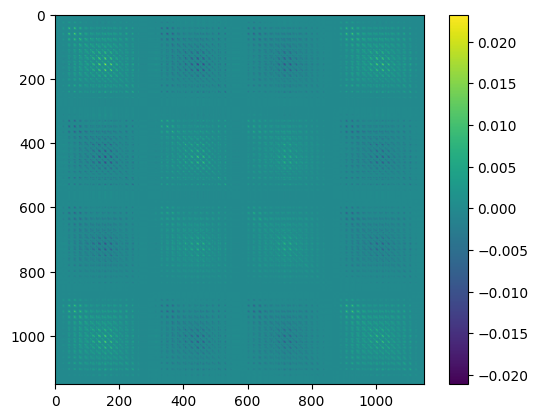

In [42]:
emprical_cov_mtx = empirical_covariance(nyu_1, assume_centered=False)
plt.imshow(emprical_cov_mtx)
plt.colorbar()

In [96]:
for site in [um1_1, um1_2, nyu_1, nyu_2]:
    print(is_pos_def(empirical_covariance(site, assume_centered=False)))

True
True
True
True


# Calculate the A matrix and b translation of the affine transform

In [66]:
c = empirical_covariance(nyu_1)
c_aff = empirical_covariance(um1_1)

c_r = sqrtm(c)
c_aff_r = sqrtm(c_aff)

mean_1_aff = np.mean(um1_1, axis=0)
mean_1 = np.mean(nyu_1, axis=0)

Q = ortho_group.rvs(dim=c_r.shape[0]) # any orthogonal mtx is ok

A_rec = c_aff_r @ Q @ np.linalg.inv(c_r)
b_rec = mean_1_aff - A_rec.dot(mean_1)
b_rec = np.expand_dims(b_rec, axis=-1)
# A_rec_inv = np.linalg.inv(A_rec)

z_original_inverse_1 = A_rec.dot(nyu_1.transpose()) + b_rec
z_original_inverse_1.shape

(1152, 12600)

# z_original mean és covar és összehas az um1-el

In [95]:
# Covariance comparison

original_cov = empirical_covariance(nyu_1)
rec_cov = empirical_covariance(z_original_inverse_1.T)
random_cov = empirical_covariance(np.random.normal(size=(12600, 1152)))

print(np.sum(np.sqrt((original_cov - rec_cov)**2)))
print(np.sum(np.sqrt((original_cov - random_cov)**2)))

3099.993734185876
10648.700624225748


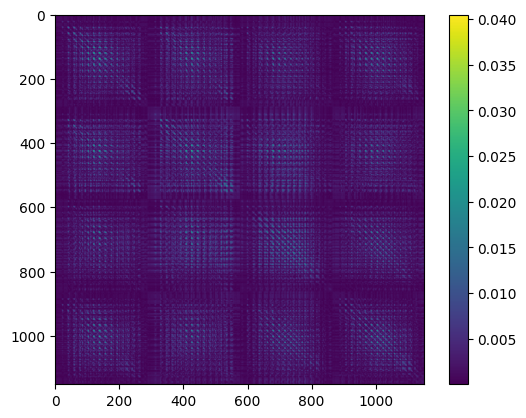

In [89]:
plt.imshow(np.sqrt((original_cov - rec_cov)**2))
plt.colorbar()
plt.show()

In [91]:
# Mean comparison

diff = np.mean(nyu_1, axis=0) - np.mean(z_original_inverse_1.T, axis=0)
diff_rand = np.mean(nyu_1, axis=0) - np.mean(np.random.normal((12600, 1152)), axis=0)
diff_sites = np.mean(nyu_1, axis=0) - np.mean(um1_1, axis=0)
np.sum(np.sqrt(diff**2)), np.sum(np.sqrt(diff_rand**2)), np.sum(np.sqrt(diff_sites**2))

(76.04537154489839, 7922683.977300536, 76.04537153064166)